In [364]:
%matplotlib inline
%reset
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import scipy

import SchemDraw as schem # to draw schematics (install using 'pip install SchemDraw')
import SchemDraw.elements as e

import skrf as rf # scikit-rf (install using 'conda -c scikit-rf scikit-rf')

import sympy # sympy (install using 'conda -c sympy sympy')
from sympy import I # imaginary symbol

rf.stylely() # enable scikit-rf plot styles
sympy.init_printing(use_latex='mathjax') # print sympy equations in MathJAX (for Jupyter)
# Useful links:
# http://www.qsl.net/in3otd/electronics/Z_fitting/impedance_fitting.html

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [365]:
# sympy fun! - just for reference
# x = sympy.symbols('x')
# display(sympy.diff(sympy.sin(x) * sympy.exp(x), x))
# display(sympy.integrate(sympy.sin(x**2), (x, -sympy.oo, sympy.oo)))
# sympy.subs - expr.subs([(sym1, val1), (sym2, val2)]) WARNING: not very performant use lambdify instead with numpy
# sympy.Eq (sets 2 expressions equal symbolically (dont use ==))
# sympy.simplify (to check symbolic equality: simplify(expr1 - expr2))
# sympy.equals (test expression equality with random numerical evaluation) expr1.equals(expr2)
# sympy.Integer(x) - creates SymPy integer
# sympy.Rational(x,y) - creates symbolic fraction
# sympy.evalf - expr.evalf() - evaluates numerical expression into floating point number
# sympy.lambdify((sym1, sym2, sym3), expr, "numpy") - returns a function

In [409]:
# helper functions
def ll(a, b): # return a and b in parallel (symbolically)
    return (a * b) / (a + b)
def mag2db(mag):
    return np.multiply(20.0, np.log10(mag))
def db2mag(db):
    return np.power(10, np.divide(db, 20.0))
def rad2deg(rad):
    return np.multiply(np.divide(rad, (2*np.pi)), 360.0)
def deg2rad(deg):
    return np.multiply(np.divide(deg, 360.0), 2*np.pi)

In [416]:
# Collected data
sma_dummy_short_data = rf.Network('data/sma_dummy_short.S2P')
small_tline_data = rf.Network('original_data/thru_0p7mm.s2p')['0.4-2Ghz']
open_data = rf.Network('original_data/OPEN.S2P')['0.2-1.0Ghz']

In [417]:
def sma_dummy_short_model():
    # Symbolic
    R, L, C, w = sympy.symbols('R L C \omega', real=True)
    L_j = I * w * L
    C_j = (I * w * C)**-1
    Z11 = sympy.simplify(ll(L_j + R, C_j))
    Z11_function = sympy.lambdify((w, C, L, R), Z11, "numpy")
    print("SMA Dummy Short Z11 Symbolic Model:")
    display(Z11)
    
    # Schematic
    print("SMA Dummy Short Schematic Model:")
    d = schem.Drawing(unit=1.5)
    C_sma = d.add(e.CAP, d='up', label='$C_{sma}$')
    d.add(e.RES, d='right', label='$R_{sma}$')
    L_sma = d.add(e.INDUCTOR, d='right', label='$L_{sma}$')
    d.add(e.RES, d='down', botlabel='$R_{short}$')
    L_short = d.add(e.INDUCTOR, d='down', botlabel='$L_{short}$')
    d.add(e.LINE, d='right', l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', xy=L_sma.end, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, d='left', xy=C_sma.end, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, xy=C_sma.start, to=L_short.end)
    d.add(e.LINE, d='left', xy=C_sma.start, l=1)
    d.add(e.DOT_OPEN)
    d.draw()
    return Z11_function

def open_model():
    # Symbolic
    C_fr, C_pp, w = sympy.symbols('C_fr C_pp \omega', real=True)
    C_fr_j = (I * w * C_fr)**-1
    C_pp_j = (I * w * C_pp)**-1
    Z11 = sympy.simplify(ll(C_fr_j + C_pp_j, C_pp_j))
    Z11_function = sympy.lambdify((w, C_fr, C_pp), Z11, "numpy")
    print("Open Z11 Symbolic Model:")
    display(Z11)

    # Schematic
    print("Open Schematic Model:")
    d = schem.Drawing(unit=2)
    port1_gnd = d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', l=1)
    C_pp1 = d.add(e.CAP, d='up', label='$C_{pp}$')
    C_fr = d.add(e.CAP, d='right', label='$C_{fr}$')
    C_pp2 = d.add(e.CAP, d='down', botlabel='$C_{pp}$')
    d.add(e.LINE, d='right', l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', xy=C_fr.end, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, xy=C_pp1.start, tox=C_pp2.end)
    d.add(e.LINE, d='left', xy=C_fr.start, l=1)
    d.add(e.DOT_OPEN)
    d.draw()
    return Z11_function

def via_model():
    # Symbolic
    C_fr, C_pp, w = sympy.symbols('C_fr C_pp \omega', real=True)
    C_fr_j = (I * w * C_fr)**-1
    C_pp_j = (I * w * C_pp)**-1
    Z11 = sympy.simplify(ll(C_fr_j + C_pp_j, C_pp_j))
    Z11_function = sympy.lambdify((w, C_fr, C_pp), Z11, "numpy")
    print("Open Z11 Symbolic Model:")
    display(Z11)


SMA Dummy Short Z11 Symbolic Model:


     -ⅈ⋅(ⅈ⋅L⋅\omega + R)     
─────────────────────────────
C⋅\omega⋅(ⅈ⋅L⋅\omega + R) - ⅈ

SMA Dummy Short Schematic Model:


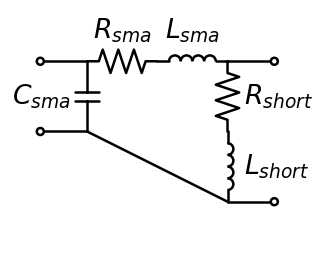

In [418]:
sma_dummy_short_model = sma_dummy_short_model()

Open Z11 Symbolic Model:


     -ⅈ⋅(C_fr + Cₚₚ)     
─────────────────────────
Cₚₚ⋅\omega⋅(2⋅C_fr + Cₚₚ)

Open Schematic Model:


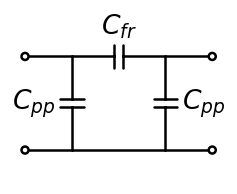

In [419]:
open_model = open_model()

In [435]:
def optimize_for_Z11(model, x0, measured_data, debug=False):
    measured_Z11 = measured_data.z[:,0,0]
    measured_omega = measured_data.frequency.w
    
    def objective_fn(guess):
        if debug:
            print("guess: ", guess)
        model_args_packed = [np.tile(x, len(measured_omega)) for x in guess]
        model_Z11 = model(measured_omega, *model_args_packed)
        MSE = (1.0 / len(measured_omega)) \
            * np.sum(np.abs(np.subtract(np.log(np.abs(model_Z11)), np.log(np.abs(measured_Z11)))))
        # Steer the optimizer away from excessively small component values
        if np.any(guess < 1e-17):
            MSE = MSE + MSE*(10**10)
        if debug:
            print("error: %f" % MSE)
        return MSE
    
    model_fit = scipy.optimize.minimize(objective_fn, x0, method='Nelder-Mead')
    return model_fit

def compare_fit_with_data(model, model_fit_params, measured_data, title=''):
    measured_Z11 = measured_data.z[:,0,0]
    measured_omega = measured_data.frequency.w
    measured_f = np.divide(measured_omega, 2*np.pi)
    model_fit_params_packed = [np.tile(x, len(measured_omega)) for x in model_fit_params]
    model_Z11 = model(measured_omega, *model_fit_params_packed)

    w, h = plt.figaspect(0.5)
    fig = plt.figure(figsize=(w,h))
    
    plt.subplot(2, 1, 1)
    plt.plot(measured_f, mag2db(np.abs(model_Z11)))
    plt.plot(measured_f, mag2db(np.abs(measured_Z11)))
    plt.title('$Z_{11}$ Measured vs. Model - ' + title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$|Z_{11}|$ (dB)')
    plt.legend(['Model', 'Measured'])
    
    plt.subplot(2, 1, 2)
    plt.plot(measured_f, rad2deg(np.angle(model_Z11)))
    plt.plot(measured_f, rad2deg(np.angle(measured_Z11)))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$\measuredangle Z_{11}$ (deg)')
    plt.legend(['Model', 'Measured'])

 final_simplex: (array([[  2.71278565e-13,   2.05570057e-09,   1.83401604e-01],
       [  2.71219313e-13,   2.05571540e-09,   1.83427845e-01],
       [  2.71329803e-13,   2.05557147e-09,   1.83381647e-01],
       [  2.71138288e-13,   2.05577153e-09,   1.83354749e-01]]), array([ 0.0209923 ,  0.02099237,  0.02099241,  0.02099245]))
           fun: 0.020992299434828336
       message: 'Optimization terminated successfully.'
          nfev: 172
           nit: 96
        status: 0
       success: True
             x: array([  2.71278565e-13,   2.05570057e-09,   1.83401604e-01])
L = 2.055701 nH | C = 0.271279 pF | R = 0.183402 Ohms


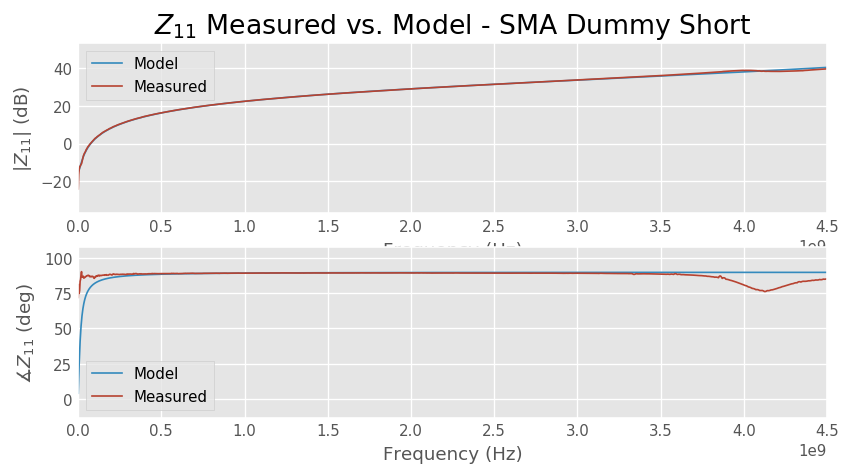

In [436]:
sma_dummy_short_fit = optimize_for_Z11(sma_dummy_short_model, (1e-12, 1e-9, 100e-3), sma_dummy_short_data)
print(sma_dummy_short_fit)
compare_fit_with_data(sma_dummy_short_model, sma_dummy_short_fit.x, sma_dummy_short_data, title='SMA Dummy Short')
print("L = %f nH | C = %f pF | R = %f Ohms" %(sma_dummy_short_fit.x[1]/1e-9, sma_dummy_short_fit.x[0]/1e-12, sma_dummy_short_fit.x[2]))

 final_simplex: (array([[  1.15898437e-14,   1.32812500e-13],
       [  1.20898437e-14,   1.32812500e-13],
       [  1.18403320e-14,   1.31835937e-13]]), array([ 0.11361866,  0.11361984,  0.11365584]))
           fun: 0.11361865997581191
       message: 'Optimization terminated successfully.'
          nfev: 49
           nit: 25
        status: 0
       success: True
             x: array([  1.15898437e-14,   1.32812500e-13])
C_fr = 11.589844 fF | C_pp = 0.132812 pF


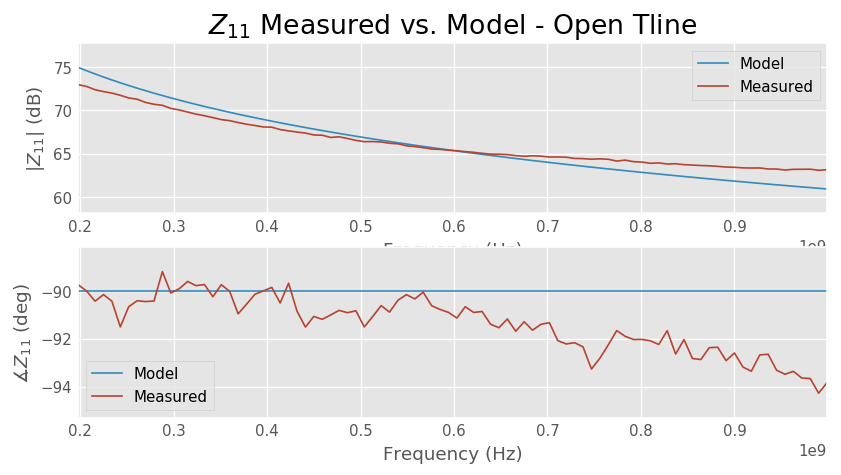

In [437]:
open_fit = optimize_for_Z11(open_model, (10e-15, 10e-12), open_data)
print(open_fit)
compare_fit_with_data(open_model, open_fit.x, open_data, title='Open Tline')
print("C_fr = %f fF | C_pp = %f pF" %(open_fit.x[0]/1e-15, open_fit.x[1]/1e-12))